# Index Funds with Mixed-Integer-Programming

We will analyze daily price data for stocks in the Dow Jones index and then try to build an accurate index fund using a small numbers of stocks therein.

Similar material was already used in a presentation at PyData Berlin 2017. See the ["Tour of popular packages" notebook](http://nbviewer.jupyter.org/github/daveh19/pydataberlin2017/blob/master/notebooks/02%20Tour%20of%20popular%20packages.ipynb). Back then, we worked with Julia 0.6 and used the packages `DataFrames`, `Plots` and `JuMP`. Now, we work with Julia 1.0 and use packages from the `Queryverse`, `VegaLite` and `IndexedTables` for data prep and visualization. Also, I added an alternative model.

## Loading the Data

In [1]:
using Queryverse
using IndexedTables: ndsparse

The data consists of daily closing prices from 2016 of the 30 stocks that participate in the Dow Jones and are given in a [CSV file](https://leethargo.github.io/files/dowjones2016.csv):

In [2]:
;head -n4 ../files/dowjones2016.csv

Date,Symbol,Price
2016-01-04,AAPL,105.349997999999999
2016-01-04,AXP,67.589995999999999
2016-01-04,BA,140.500000000000000


In [3]:
price = load("../files/dowjones2016.csv") |> ndsparse
price |> @take(3)

3x3 query result
Date       │ Symbol │ Price 
───────────┼────────┼───────
2016-01-04 │ AAPL   │ 105.35
2016-01-04 │ AXP    │ 67.59 
2016-01-04 │ BA     │ 140.5

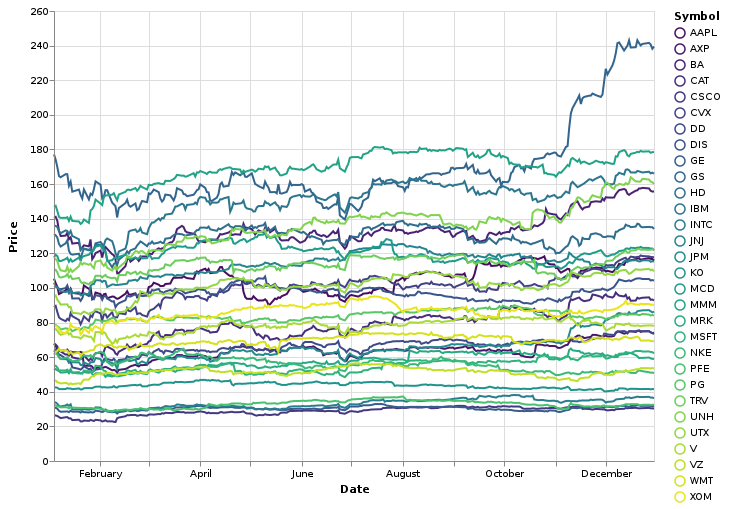

In [4]:
price |> @vlplot(:line, x=:Date, y=:Price, color={"Symbol:o", scale={scheme="viridis"}},
                 width=600, height=450)

## Computing the Dow Jones Index

The Dow Jones index is computed from the prices of its stocks, as a weighted average, where the weight is itself defined through the price of the stock.

We will compute the average price of each stock over the days. Then we will normalize these values by dividing through the total of the average prices. The normalized weights are then multiplied to the daily prices to get the daily value of the index.

In [5]:
using Statistics: mean

In [6]:
avgprice = price |>
    @groupby(_.Symbol) |>
    @map({Symbol=key(_), AvgPrice=mean(_.Price)}) |> ndsparse
avgprice |> @take(4)

4x2 query result
Symbol │ AvgPrice
───────┼─────────
AAPL   │ 104.604 
AXP    │ 63.7933 
BA     │ 133.112 
CAT    │ 78.698

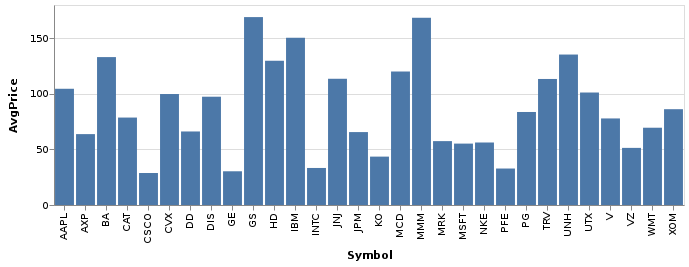

In [7]:
avgprice |> @vlplot(:bar, x=:Symbol, y=:AvgPrice)

In [8]:
totalavg = avgprice |> @map(_.AvgPrice) |> sum

2617.739246769842

In [9]:
weight = avgprice |> @map({Symbol=_.Symbol, Weight=_.AvgPrice / totalavg}) |> ndsparse
weight |> @take(4)

4x2 query result
Symbol │ Weight   
───────┼──────────
AAPL   │ 0.0399597
AXP    │ 0.0243696
BA     │ 0.0508498
CAT    │ 0.0300634

In [10]:
dowjones = price |> 
    @join(weight, _.Symbol, _.Symbol, {_.Date, _.Symbol, Contrib=_.Price * __.Weight}) |>
    @groupby(_.Date) |>
    @map({Date=key(_), Value=sum(_.Contrib)}) |> ndsparse
dowjones |> @take(4)

4x2 query result
Date       │ Value  
───────────┼────────
2016-01-04 │ 100.573
2016-01-05 │ 100.511
2016-01-06 │ 99.0142
2016-01-07 │ 96.606

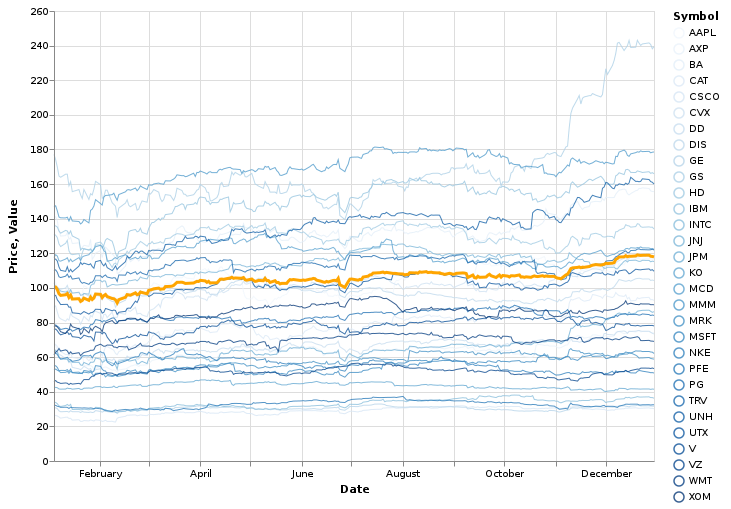

In [11]:
@vlplot(width=600, height=450) +
@vlplot(mark={:line, strokeWidth=1, opacity=0.8}, data=price, x=:Date, y=:Price,
        color={"Symbol:n", scale={scheme="blues"}}) +
@vlplot(mark={:line, strokeWidth=3, color=:orange}, data=dowjones, x=:Date, y=:Value)

In the previous plot, the Dow Jones index is marked in orange. In the following, it will be our target, which we want to approximate by using a small number of the stocks.

# Model for Linear Fit

Let us start with an optimization model similar to an ordinary linear regression, but using the l1-norm, which is readily formulated as a linear program. In compact vector form, this reads

\begin{align*}
\text{minimize} \quad   & \lVert w^T P - I \rVert_1 \\
\text{subject to} \quad & w \ge 0
\end{align*}

where $P$ stands for the prices of the individual st, $I$ for our index (the target) and $w$ for the weights we use in our fund. We only allow non-negative weights for use in the portfolio.

We can use a standard linear programming trick and introduce auxiliary variables for the positive and negative parts inside the absolute values and minimize their sum. This is formulated using JuMP:

In [12]:
using JuMP
using SCIP

In [13]:
dates = unique(price.index.columns.Date)
symbols = unique(price.index.columns.Symbol)

length(dates), length(symbols)

(252, 30)

We could use all days of the year as input for our model, but for our evaluation we only use the days from the first three quarters. That way, we can see how our fit extrapolates through the remaining quarter.

In [14]:
training_days = 189
traindates = dates[1:training_days]
testdates = dates[training_days + 1:end]
@show traindates[end] testdates[1]

# for visualization
datebreak = [(Date=traindates[end],)] |> @take(1)

length(traindates), length(testdates)

traindates[end] = 2016-09-30
testdates[1] = 2016-10-03


(189, 63)

In [15]:
function solve_index_linear()
    m = Model(solver=SCIPSolver("display/verblevel", 2))
    
    @variable(m, weight[symbols] >= 0)
    @variable(m, posdev[traindates] >= 0)
    @variable(m, negdev[traindates] >= 0)
    
    for d in traindates
        @constraint(m, sum(weight[s]*price[d,s][1] for s in symbols) - dowjones[d][1] == posdev[d] - negdev[d])
    end
    
    @objective(m, :Min, sum(posdev[d] + negdev[d] for d in traindates))
    
    status = solve(m)
    return (
        status = status,
        weight = getvalue(weight),
    )
end

solve_index_linear (generic function with 1 method)

In [16]:
sol = solve_index_linear()
sol.status

:Optimal

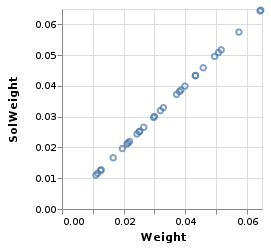

In [17]:
solweight = [(Symbol=s, SolWeight=sol.weight[s]) for s in symbols]
weight |>
    @join(solweight, _.Symbol, _.Symbol, {_.Symbol, _.Weight, __.SolWeight}) |>
    @vlplot(:point, x=:Weight, y=:SolWeight)

In the scatter chart above, we compare the weights from the Dow Jones index, with the weights found by the LP model. As we can see (the points lie on the diagonal), we recover the actual weights perfectly, even though we are only using a subset of the data.

# Model with Sparsity Constraint

The last model gave us an exact fit, but used all available stocks.

We are changing it now, and allow it to use only a given number of stocks. For this end, we will introduce additional binary variables to select stocks to become active in our index fund.

The weight of inactive variables must be forced to 0, which we do with a so-called *big-M* constraint. The constant is chosen in such a way, that any active stock could single-handedly approximate the target index.

In [18]:
bigM = 1 / minimum(weight.data.columns[1])

90.926297738811

We start by using only a single stock and then go up to subsets of 6 stocks out of the 30.

In [19]:
nstocks_range = 1:6

1:6

The model seems to be relatively difficult to solve for SCIP, probably because of the *big-M* constraints, so we set a gap limit of 5%, rather than solving to proven optimality.

In [20]:
function solve_index_sparse(nstocks)
    m = Model(solver=SCIPSolver("display/verblevel", 2, "limits/gap", 0.05))
    
    @variable(m, active[symbols], Bin)
    @variable(m, weight[symbols] >= 0)
    @variable(m, posdev[traindates] >= 0)
    @variable(m, negdev[traindates] >= 0)
    
    for d in traindates
        @constraint(m, sum(weight[s]*price[d,s][1] for s in symbols) - dowjones[d][1] == posdev[d] - negdev[d])
    end

    for s in symbols
        @constraint(m, weight[s] <= bigM*active[s])
    end
    
    @constraint(m, sum(active[s] for s in symbols) <= nstocks)
    
    @objective(m, :Min, sum(posdev[d] + negdev[d] for d in traindates))
    
    status = solve(m, suppress_warnings=true)
    return (
        status = status,
        weight = getvalue(weight)
    )
end

solve_index_sparse (generic function with 1 method)

In [21]:
sols = [solve_index_sparse(n) for n in nstocks_range];

We extract the model solutions and concatenate them into a table for visualization.

In [22]:
solweight = [(NStocks=n, Symbol=s, SolWeight=sols[n].weight[s]) for n in nstocks_range for s in symbols] |>
            @filter(_.SolWeight > 0.0)
solweight |> @take(3)

3x3 query result
NStocks │ Symbol │ SolWeight
────────┼────────┼──────────
1       │ TRV    │ 0.91443  
2       │ BA     │ 0.394428 
2       │ MMM    │ 0.313139

In [23]:
indices = price |>
    @join(solweight, _.Symbol, _.Symbol, {__.NStocks, _.Date, _.Symbol, Contrib=_.Price * __.SolWeight}) |>
    @groupby({_.NStocks, _.Date}) |>
    @map({NStocks=_.NStocks[1], Date=_.Date[1], Value=sum(_.Contrib)}) |> ndsparse
indices |> @take(3)

3x3 query result
NStocks │ Date       │ Value  
────────┼────────────┼────────
1       │ 2016-01-04 │ 100.56 
1       │ 2016-01-05 │ 101.017
1       │ 2016-01-06 │ 99.7094

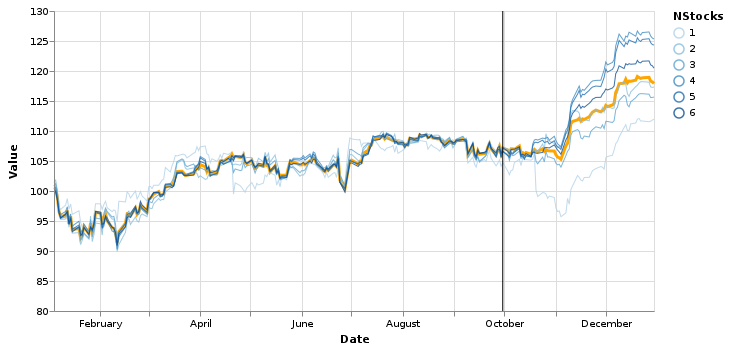

In [24]:
@vlplot(width=600, height=300) +
@vlplot(mark={:line, color=:orange, strokeWidth=3},
        data=dowjones, x=:Date, y={:Value, scale={domain=[80, 125]}}) +
@vlplot(mark={:line, strokeWidth=1, opacity=0.8},
        data=indices, x=:Date, y=:Value, color="NStocks:o") +
@vlplot(:rule, data=datebreak, x=:Date)

As we can see, our solutions stick to the target fund quite closely during the training period, but then diverge from it quickly. Allowing more stocks gives us a better fit.

# Computing Returns

In the previous model, we tried to fit our index fund to the absolute day-to-day closing prices. But the next model will be based on picking representative that are similar, which is defined through correlation of returns.

So let's start by computing daily returns from the closing prices (for the training period).

In [25]:
prevdates = (Date=dates[2:end], PrevDate=dates[1:end-1])
prevdates |> @take(3)

3x2 query result
Date       │ PrevDate  
───────────┼───────────
2016-01-05 │ 2016-01-04
2016-01-06 │ 2016-01-05
2016-01-07 │ 2016-01-06

In [26]:
price[:, "AAPL"] |> @take(3)

returns = prevdates |>
    @filter(_.Date <= traindates[end]) |>
    @join(price, _.Date, _.Date, {_.Date, _.PrevDate, __.Symbol, __.Price}) |>
    @join(price, {Date=_.PrevDate, _.Symbol}, {_.Date, _.Symbol},
                 {__.Symbol, _.Date, Return=_.Price / __.Price - 1.0}) |>
    ndsparse
returns |> @take(3)

3x3 query result
Symbol │ Date       │ Return    
───────┼────────────┼───────────
AAPL   │ 2016-01-05 │ -0.0250593
AAPL   │ 2016-01-06 │ -0.0195697
AAPL   │ 2016-01-07 │ -0.0422046

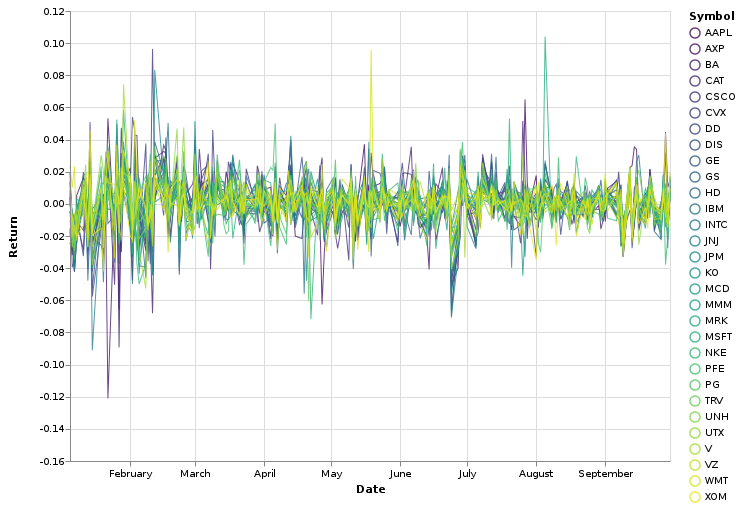

In [27]:
returns |>
    @vlplot(mark={:line, opacity=0.8, strokeWidth=1}, width=600, height=450,
            x=:Date, y=:Return, color={"Symbol:o", scale={scheme="viridis"}})

# Analyzing Correlation

We compute pair-wise correlation of the 30 stocks, but first need to compute the mean and standard deviations of the returns.

In [28]:
returnagg = returns |>
    @groupby(_.Symbol) |>
    @map({Symbol=key(_), MeanReturn=mean(_.Return)}) |>
    @join(returns, _.Symbol, _.Symbol,
          {_.Symbol, __.Date, _.MeanReturn, ShiftedSqr=(__.Return - _.MeanReturn)^2}) |>
    @groupby(_.Symbol) |>
    @map({Symbol=key(_), MeanReturn=_.MeanReturn[1],
          StdDevReturn=sqrt(sum(_.ShiftedSqr)/(length(_) - 1))})
returnagg |> @take(3)

3x3 query result
Symbol │ MeanReturn   │ StdDevReturn
───────┼──────────────┼─────────────
AAPL   │ 0.000503948  │ 0.0160686   
AXP    │ -0.000165808 │ 0.0153556   
BA     │ -0.000207316 │ 0.0163469

The mean and standard deviation of the stock returns can be used as performance and risk markers. In the following scatter chart, we give an overview of these (bottom right is best). 

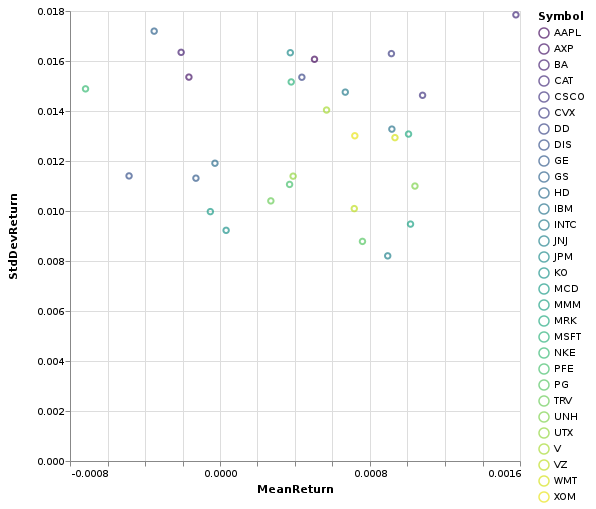

In [29]:
returnagg |>
    @vlplot(:point, x=:MeanReturn, y=:StdDevReturn, color={"Symbol:o", scale={scheme="viridis"}},
            width=450, height=450)

In [30]:
shiftedreturns = returns |>
    @join(returnagg, _.Symbol, _.Symbol, {_.Symbol, _.Date, ShiftedReturn=_.Return - __.MeanReturn})
shiftedreturns |> @take(3)

3x3 query result
Symbol │ Date       │ ShiftedReturn
───────┼────────────┼──────────────
AAPL   │ 2016-01-05 │ -0.0255633   
AAPL   │ 2016-01-06 │ -0.0200736   
AAPL   │ 2016-01-07 │ -0.0427085

In [31]:
correlation = shiftedreturns |>
    @join(shiftedreturns, _.Date, _.Date,
          {Left=_.Symbol, Right=__.Symbol, Product=_.ShiftedReturn * __.ShiftedReturn}) |>
    @groupby({_.Left, _.Right}) |>
    @map({Left=_.Left[1], Right=_.Right[1], Covariance=mean(_.Product)}) |>
    @join(returnagg, _.Left, _.Symbol, {_.Left, _.Right, _.Covariance, LeftStdDev=__.StdDevReturn}) |>
    @join(returnagg, _.Right, _.Symbol,
          {_.Left, _.Right, Correlation=_.Covariance / (_.LeftStdDev * __.StdDevReturn)}) |>
    ndsparse
correlation |> @take(3)

3x3 query result
Left │ Right │ Correlation
─────┼───────┼────────────
AAPL │ AAPL  │ 0.994681   
AAPL │ AXP   │ 0.121703   
AAPL │ BA    │ 0.400597

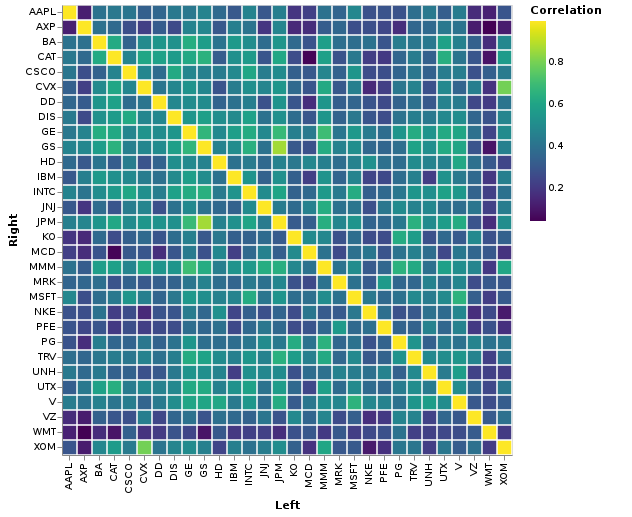

In [32]:
correlation |>
    @vlplot(:rect, x=:Left, y=:Right, color=:Correlation, width=450, height=450)

As we can see here, all of the stocks are either unrelated or positively related, but never negatively related, which is not at all obvious to me.

# Model for Picking Representatives

The following model is taken from the book [Optimization Methods in Finance](http://www.cambridge.org/us/catalogue/catalogue.asp?isbn=9780511258183).

Rather than looking at the day-to-day values, it precomputes a similary for each pair of stocks, and then selects a representative for each stock while limiting the total number of representatives. The actual weight given to the stocks is not part of the model, but computed in a post-processing step.

The authors note that this model can be solved more efficiently using a Lagrangian Relaxation approach, but I found that this is not necessary for our small dataset.

In [33]:
function solve_index_repr(nstocks)
    m = Model(solver=SCIPSolver("display/verblevel", 2))
    
    @variable(m, active[symbols], Bin)       # is stock in index fund?
    @variable(m, repr[symbols,symbols], Bin) # is stock 'r' represented by 's'?
    
    @constraint(m, sum(active[s] for s in symbols) <= nstocks)
    
    for r in symbols
        for s in symbols
            @constraint(m, repr[r,s] <= active[s])
        end
    end
    
    for r in symbols
        @constraint(m, sum(repr[r,s] for s in symbols) == 1)
    end
    
    @objective(m, :Max, sum(correlation[r,s][1] * repr[r,s] for r in symbols for s in symbols))
    
    status = solve(m, suppress_warnings=true)
    
    # post-processing: determine weights for representatives
    reprsol = getvalue(repr)
    accweight = [sum(weight[r][1] * reprsol[r,s] for r in symbols)/avgprice[s][1] for s in symbols]
                    
    return (
        status = status,
        active = getvalue(active),
        weight = accweight * mean(dowjones.data.columns.Value)
    )
end

solve_index_repr (generic function with 1 method)

In [34]:
sols_repr = [solve_index_repr(n) for n in nstocks_range];

In [35]:
reprweight = [(NStocks=n, Symbol=s, SolWeight=w) for n in nstocks_range
              for (s,w) in zip(symbols,sols_repr[n].weight)] |>
            @filter(_.SolWeight > 0.0)
reprweight |> @take(3)

3x3 query result
NStocks │ Symbol │ SolWeight
────────┼────────┼──────────
1       │ GE     │ 3.47077  
2       │ MMM    │ 0.409427 
2       │ V      │ 0.466415

In [36]:
reprindices = price |>
    @join(reprweight, _.Symbol, _.Symbol, {__.NStocks, _.Date, _.Symbol, Contrib=_.Price * __.SolWeight}) |>
    @groupby({_.NStocks, _.Date}) |>
    @map({NStocks=_.NStocks[1], Date=_.Date[1], Value=sum(_.Contrib)}) |> ndsparse
reprindices |> @take(3)

3x3 query result
NStocks │ Date       │ Value  
────────┼────────────┼────────
1       │ 2016-01-04 │ 106.587
1       │ 2016-01-05 │ 106.691
1       │ 2016-01-06 │ 104.991

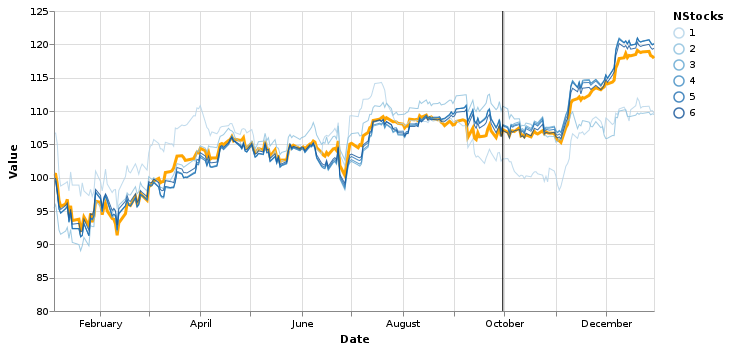

In [37]:
@vlplot(width=600, height=300) +
@vlplot(mark={:line, color=:orange, strokeWidth=3},
        data=dowjones, x=:Date, y={:Value, scale={domain=[80, 125]}}) +
@vlplot(mark={:line, strokeWidth=1, opacity=0.8},
        data=reprindices, x=:Date, y=:Value, color="NStocks:o") +
@vlplot(:rule, data=datebreak, x=:Date)

We can see that the solution funds are not following the target index as closely as before, on a day-to-day basis, but the general *shape* of the curve is very similar. On the other hand, there seems to be hardly any difference in performance between the training and the test period, so it extrapolates quite well!

# Comparison of methods

We could compare the approaches more systematically, by computing the losses with different norms (l1, or l2) on the training or test data, but I feel the visualization already gives a good enough impression.

But as a final comparison, let us count how often the different stocks are used for the index funds.

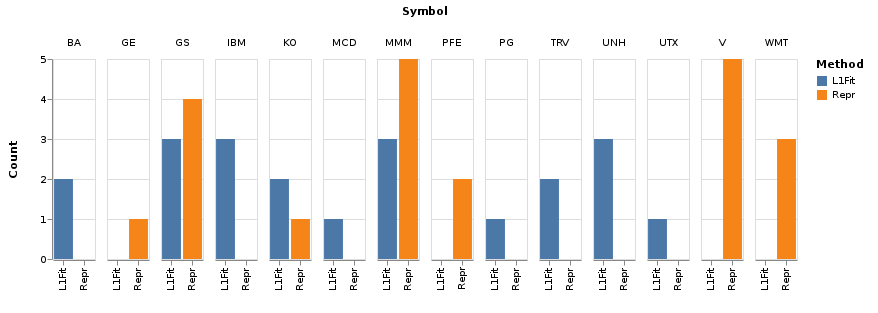

In [38]:
count1 = solweight |>
    @groupby(_.Symbol) |>
    @map({Symbol=key(_), Method="L1Fit", Count=length(_)}) |>
    @orderby_descending(_.Count)
count2 = reprweight|>
    @groupby(_.Symbol) |>
    @map({Symbol=key(_), Method="Repr", Count=length(_)}) |>
    @orderby_descending(_.Count)

counts = [count1...; count2...] |> ndsparse

counts |>
    @vlplot(:bar, column=:Symbol, x={field=:Method, axis={title=""}}, y=:Count, color=:Method)

It looks like the two model have very different taste in stocks and can only agree on 2-3 of them!

# Notes on packages used

Since this blog was also an exercise in using `Queryverse` and `VegaLite`, I would like to comment on my experience now.
For `Query` itself, building the queries was relatively straight-forward, after watching the [tutorial](https://www.youtube.com/watch?v=2oXSA2w-p28) given by David Anthoff at JuliaCon 2018.

Some of the computations look quite awkward and are probably not efficient either, such as the twofold join of `price` with itself and another table that links each day with the previous day. Here, an array-based view using `[2:end]` and `[1:end-1]` would have been more natural. Also, after a while I found it a little annoying that I had to repeatedly name all of the columns that I wanted to keep, in `@join` or `@map` calls.

Finally, the combination of `Query` and `ndsparse` of `IndexedTables.jl` is a little unfortunate, when the latter one is used as a sink for some query. Typically, `ndsparse` is constructed with a set of columns to be used as an index, and another (single, unnamed) column as a value. Individual values can then be referenced just like an array, that is, `table[i,j]`. But the constructor of `ndsparse` used on query results takes the first $n - 1$ columns as index and the last as value, but wrapped in a singledton `NamedTuple`. So, `table[i,j]` will actually be a `(k=23,)`. This meant that I had to use `price[d,s][1]` as coefficient in my model, rather than simply `price[d,s]`. I could not figure out how to avoid this, without creating essentially another copy of the data.